In [68]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pickle
from sklearn.model_selection import StratifiedKFold
import numpy as np
import pandas as pd
import pickle
import pprint 
from sklearn.metrics import roc_auc_score
from keras import models
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPool2D
from keras.layers import Reshape, Flatten, Dropout, Concatenate
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.models import Model
from sklearn.model_selection import train_test_split
from keras import layers

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from scipy.sparse import hstack
from sklearn.ensemble import RandomForestClassifier


train = pickle.load(open('train.p','rb')).sample(1000)
test = pickle.load(open('test.p','rb')).sample(1000)

In [77]:

train_text = train['comment_text']
test_text = test
all_text = pd.concat([train_text, test_text])

word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    ngram_range=(1, 2),
    max_features=1000)
word_vectorizer.fit(all_text)
train_word_features = word_vectorizer.transform(train_text)
#test_word_features = word_vectorizer.transform(test_text)
print('word TFIDF')

char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    ngram_range=(1, 2),
    max_features=1000)
char_vectorizer.fit(all_text)
train_char_features = char_vectorizer.transform(train_text)
#test_char_features = char_vectorizer.transform(test_text)
print('char TFIDF')

train_features = hstack([train_char_features, train_word_features])
#test_features = hstack([test_char_features, test_word_features])
print(train_features.shape)


for col in ['toxic','severe_toxic','obscene','threat','insult','identity_hate']:
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=np.random.randint(1,1000))
    for ii, jj in sss.split(train.index, train[col]):
        train_index=ii.tolist()
        test_index=jj.tolist()
    X_train, X_test = train_features.tocsr()[train_index,:], train_features.tocsr()[test_index,:]
    y_train, y_test = train[col].iloc[train_index], train[col].iloc[test_index]

    sequence_length = 2000#x.shape[1] # 56
    vocabulary_size = 2000#len(vocabulary_inv) # 18765
    embedding_dim = 256
    filter_sizes = [3,4,5]
    num_filters = 512
    drop = 0.5

    epochs = 10
    batch_size = 500
    
    print("Creating Model...")
    inputs = Input(shape=(sequence_length,), batch_shape=(None, sequence_length), dtype='float32')
    print(inputs.get_shape())
    embedding = Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, input_length=sequence_length)(inputs)
    reshape = Reshape((sequence_length,embedding_dim,1))(embedding)

    conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
    conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
    conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)

    maxpool_0 = MaxPool2D(pool_size=(sequence_length - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
    maxpool_1 = MaxPool2D(pool_size=(sequence_length - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
    maxpool_2 = MaxPool2D(pool_size=(sequence_length - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)

    concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
    flatten = Flatten()(concatenated_tensor)
    dropout = Dropout(drop)(flatten)
    output = Dense(units=2, activation='softmax')(dropout)

    # this creates a model that includes
    model = Model(inputs=inputs, outputs=output)

    checkpoint = ModelCheckpoint('weights.{epoch:03d}-{val_acc:.4f}.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
    adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
    print("Traning Model...")
    model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[checkpoint], validation_data=(X_test, y_test))  # starts training


    print('AUC Score Is -----> ',roc_auc_score(y_train, preds))

    #history_dict = history.history
    #print(history_dict.keys())

    #acc =history_dict['acc']
    #val_acc =history_dict['val_acc']

# clf1 = LogisticRegression()
# clf2 = RandomForestClassifier(n_estimators=100, max_depth=4, max_features=1000, n_jobs=-1)
# clf3 = MultinomialNB()
# subm = pd.read_csv('sample_submission.csv')

# X = trn_term_doc
# for col in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']:
#     print('-----',col)
#     clf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('nb', clf3)], voting='soft', n_jobs=-1)
#     clf = clf.fit(X, train[col])
#     preds = clf.predict_proba(test_term_doc)[:,1]
#     subm[col] = preds


# from keras.preprocessing.text import Tokenizer

# tokenizer = Tokenizer(num_words=10000)
# tokenizer.fit_on_texts(train_text)

# x_train = tokenizer.texts_to_matrix(train_text,mode='tfidf')
# print(x_train)
# y_train = np.asarray(train_y).astype('float32')



word TFIDF
char TFIDF
(1000, 2000)
Creating Model...
(?, 2000)
Traning Model...


ValueError: Error when checking target: expected dense_49 to have shape (None, 2) but got array with shape (500, 1)

In [ ]:
from sklearn.metrics import roc_auc_score
from keras import models
from keras import layers
num_classes =6

model = models.Sequential()

model.add(layers.Dense(32,activation='relu',input_shape=(10000,)))
model.add(layers.Dense(32,activation='relu'))
model.add(layers.Dense(num_classes,activation='sigmoid'))
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])


history = model.fit(x_train,y_train,epochs=8,batch_size=512, validation_split=0.2)
preds = model.predict(x_train)
print(roc_auc_score(y_train, preds))

history_dict = history.history
print(history_dict.keys())

acc =history_dict['acc']
val_acc =history_dict['val_acc']

In [46]:


print('Loading data')
x, y, vocabulary, vocabulary_inv = load_data()

X_train, X_test, y_train, y_test = train_test_split( x, y, test_size=0.2, random_state=42)



# this returns a tensor
print("Creating Model...")
inputs = Input(shape=(sequence_length,), dtype='int32')
embedding = Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, input_length=sequence_length)(inputs)
reshape = Reshape((sequence_length,embedding_dim,1))(embedding)

conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)

maxpool_0 = MaxPool2D(pool_size=(sequence_length - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(sequence_length - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(sequence_length - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)

concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(concatenated_tensor)
dropout = Dropout(drop)(flatten)
output = Dense(units=2, activation='softmax')(dropout)

# this creates a model that includes
model = Model(inputs=inputs, outputs=output)

checkpoint = ModelCheckpoint('weights.{epoch:03d}-{val_acc:.4f}.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
print("Traning Model...")
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[checkpoint], validation_data=(X_test, y_test))  # starts training








2

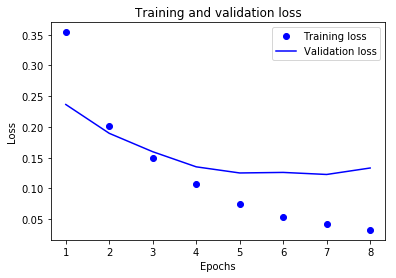

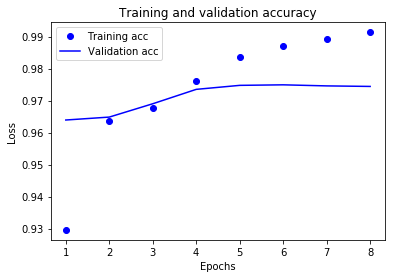

KeyError: 'id'

In [4]:

#Plot the training and val loss and accuracy
import matplotlib.pyplot as plt

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(acc) + 1)


plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


plt.clf()
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
def read_data_test(test_data):
    data_comments = []
    for index, row in test_data.iterrows():
        comment = row.comment_text
        if comment is not np.nan:
            data_comments.append(comment)
    return data_comments

#test = pd.read_csv('../input/test.csv',encoding='utf-8',error_bad_lines=False)

#test_comments = read_data_test(test)

tokenizer.fit_on_texts(test_text)
x_test = tokenizer.texts_to_matrix(test_text,mode='tfidf')

# values of probabilities for each id
probabilities =model.predict(x_test)

#creating dataframe
prob_df= pd.DataFrame(probabilities)


#creating dataframe of id's
id_df = test['id']


#final results will be
results = pd.concat([id_df,prob_df],axis=1)

print(results)

# results.to_csv('final_results.csv',index=False)
